In [1]:
import numpy as np
import torch 
import torch.nn as nn
from tqdm import tnrange
import torch.optim as optim
import torch.nn.functional as F
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import explained_variance_score
import scipy
import time

#from models.glm import GLM
#from models.tcn import TCN
#from models.sub_tcn import Sub_TCN
from models.sub_cos_tcn import Sub_Cos_TCN

In [2]:
cos_basis_no = 24
scale = 6
shift = 1
        
kern_basis = torch.zeros(cos_basis_no, 500)
for i in range(cos_basis_no):
    phi = 1.5707963267948966*i
    xmin = phi - 3.141592653589793
    xmax = phi + 3.141592653589793

    x_in = torch.arange(0, 500, 1)
    raw_cos = scale  * torch.log(x_in + shift + 1e-7)

    basis = 0.5*torch.cos(raw_cos - phi) + 0.5
    basis[raw_cos < xmin] = 0.0
    basis[raw_cos > xmax] = 0.0
    kern_basis[i] = basis

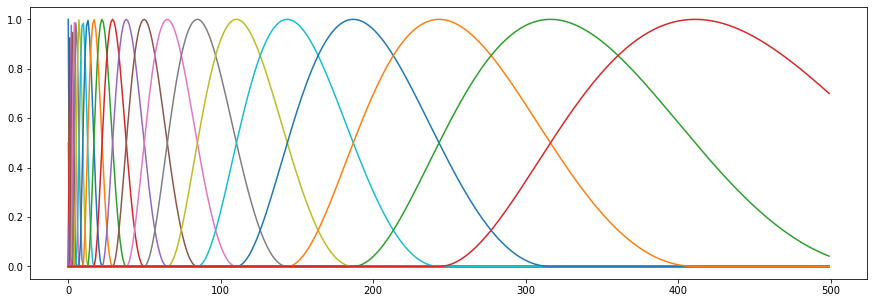

In [3]:
plt.figure(figsize = (15,5))
for i in range(cos_basis_no):
    plt.plot(kern_basis[i])

# Hyperparameters

In [2]:
base_dir = "/media/hdd01/sklee/"
experiment = "clust4-60"
cell_type = "CA1"
E_neural_file = "Espikes_neural.npz"
I_neural_file = "Ispikes_neural.npz"
#V_file = "vdata_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_Er0.5_Ir7.4_random_NR_rep1000_stimseed1.npy"
V_file = "V_diff.npy"
eloc_file = "Elocs_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_Er0.5_Ir7.4_random_NR_rep1000_stimseed1.npy"
iloc_file = "Ilocs_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_Er0.5_Ir7.4_random_NR_rep1000_stimseed1.npy"

E_neural = scipy.sparse.load_npz(base_dir+cell_type+"_"+experiment+"/data/"+E_neural_file)
I_neural = scipy.sparse.load_npz(base_dir+cell_type+"_"+experiment+"/data/"+I_neural_file)
#V = np.load(base_dir+cell_type+"_"+experiment+"/data/"+V_file)[:,:50000].flatten()
V = np.load(base_dir+cell_type+"_"+experiment+"/data/"+V_file)
V = torch.from_numpy(V)
#V -= torch.mean(V)
eloc = np.load(base_dir+cell_type+"_"+experiment+"/data/"+eloc_file)
iloc = np.load(base_dir+cell_type+"_"+experiment+"/data/"+iloc_file)

den_idx = np.unique(eloc[880:1120,0])
e_idx = np.where(np.isin(eloc[:,0], den_idx) == True)[0]
i_idx = np.where(np.isin(iloc[:,0], den_idx) == True)[0]
e_idx = torch.from_numpy(e_idx)
i_idx = torch.from_numpy(i_idx)

part_C_syn_e = np.load("/media/hdd01/sklee/CA1_clust4-60/data/handsub6_C_syn_e.npy")
part_C_syn_i = np.load("/media/hdd01/sklee/CA1_clust4-60/data/handsub6_C_syn_i.npy")
part_C_syn_e = torch.from_numpy(part_C_syn_e)
part_C_syn_i = torch.from_numpy(part_C_syn_i)

In [3]:
T_train = 992 * 1000 * 50
T_test = 1 * 1000 * 50
H_no = 2
sub_no = 4
two_nonlin = False
E_no = 2000
I_no = 200
T_no = 500
device = torch.device("cuda")

batch_length = 50000
batch_size = 4
iter_no = 9920*2
epoch_no = iter_no*batch_length*batch_size//T_train 

# Preprocess

In [4]:
V_train = V[:T_train].float()
V_test = V[T_train:T_train + T_test].to(device).float()

test_E_neural = E_neural[T_train:T_train+T_test].toarray()
test_I_neural = I_neural[T_train:T_train+T_test].toarray()
train_E_neural = E_neural[:T_train]
train_I_neural = I_neural[:T_train]

test_E_neural = torch.from_numpy(test_E_neural).float().to(device)
test_I_neural = torch.from_numpy(test_I_neural).float().to(device)

train_idx = np.empty((epoch_no, T_train//batch_length//batch_size))
for i in range(epoch_no):
    part_idx = np.arange(0, T_train, batch_length*batch_size)
    np.random.shuffle(part_idx)
    train_idx[i] = part_idx
train_idx = train_idx.flatten()
train_idx = torch.from_numpy(train_idx)

In [5]:
C_syn_e = torch.zeros(sub_no, E_no).to(device)
C_syn_i = torch.zeros(sub_no, I_no).to(device)

for i in range(E_no):
    den = eloc[i,0]
    if den == den_idx[0]:
        C_syn_e[0,i] = 1
    elif den == den_idx[1]:
        C_syn_e[1,i] = 1
    elif den == den_idx[2]:
        C_syn_e[2,i] = 1
    elif den == den_idx[3]:
        C_syn_e[3,i] = 1

for i in range(I_no):
    den = iloc[i,0]
    if den == den_idx[0]:
        C_syn_e[0,i] = 1
    elif den == den_idx[1]:
        C_syn_e[1,i] = 1
    elif den == den_idx[2]:
        C_syn_e[2,i] = 1
    elif den == den_idx[3]:
        C_syn_e[3,i] = 1

In [6]:
"""
C_syn_e = torch.zeros(sub_no, E_no).to(device)
C_syn_e[:6] = part_C_syn_e

C_syn_i = torch.zeros(sub_no, I_no).to(device)
C_syn_i[:6] = part_C_syn_i

for i in range(E_no):
    den = eloc[i,0]
    if den == den_idx[0]:
        C_syn_e[:,i] = 0
        C_syn_e[6,i] = 1
    elif den == den_idx[1]:
        C_syn_e[:,i] = 0
        C_syn_e[7,i] = 1
    elif den == den_idx[2]:
        C_syn_e[:,i] = 0
        C_syn_e[8,i] = 1
    elif den == den_idx[3]:
        C_syn_e[:,i] = 0
        C_syn_e[9,i] = 1

for i in range(I_no):
    den = iloc[i,0]
    if den == den_idx[0]:
        C_syn_e[:,i] = 0
        C_syn_e[6,i] = 1
    elif den == den_idx[1]:
        C_syn_e[:,i] = 0
        C_syn_e[7,i] = 1
    elif den == den_idx[2]:
        C_syn_e[:,i] = 0
        C_syn_e[8,i] = 1
    elif den == den_idx[3]:
        C_syn_e[:,i] = 0
        C_syn_e[9,i] = 1
        
C_den = torch.zeros(sub_no, sub_no).to(device)
C_den[0,1:] = 1
"""

'\nC_syn_e = torch.zeros(sub_no, E_no).to(device)\nC_syn_e[:6] = part_C_syn_e\n\nC_syn_i = torch.zeros(sub_no, I_no).to(device)\nC_syn_i[:6] = part_C_syn_i\n\nfor i in range(E_no):\n    den = eloc[i,0]\n    if den == den_idx[0]:\n        C_syn_e[:,i] = 0\n        C_syn_e[6,i] = 1\n    elif den == den_idx[1]:\n        C_syn_e[:,i] = 0\n        C_syn_e[7,i] = 1\n    elif den == den_idx[2]:\n        C_syn_e[:,i] = 0\n        C_syn_e[8,i] = 1\n    elif den == den_idx[3]:\n        C_syn_e[:,i] = 0\n        C_syn_e[9,i] = 1\n\nfor i in range(I_no):\n    den = iloc[i,0]\n    if den == den_idx[0]:\n        C_syn_e[:,i] = 0\n        C_syn_e[6,i] = 1\n    elif den == den_idx[1]:\n        C_syn_e[:,i] = 0\n        C_syn_e[7,i] = 1\n    elif den == den_idx[2]:\n        C_syn_e[:,i] = 0\n        C_syn_e[8,i] = 1\n    elif den == den_idx[3]:\n        C_syn_e[:,i] = 0\n        C_syn_e[9,i] = 1\n        \nC_den = torch.zeros(sub_no, sub_no).to(device)\nC_den[0,1:] = 1\n'

# Train

In [7]:
#model = GLM(C_den, C_syn_e, C_syn_i, T_no, device)
model = Sub_Cos_TCN(C_syn_e, C_syn_i, T_no, H_no, two_nonlin, device)

#optimizer = torch.optim.Adam(model.parameters(), lr = 0.005) # For GLM
optimizer = torch.optim.Adam(model.parameters(), lr = 0.005) # For TCN / Sub TCN
#optimizer = torch.optim.Adam(model.parameters(), lr = 0.005) # For Cos TCN

#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.5)

model.to(device).float()
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

2601


In [8]:
score_list = []

for i in tnrange(iter_no):
    model.train()
    optimizer.zero_grad()
    
    batch_idx = train_idx[i].long()
    batch_E_neural = train_E_neural[batch_idx : batch_idx+batch_length*batch_size].toarray().reshape(batch_size, batch_length, -1)
    batch_I_neural = train_I_neural[batch_idx : batch_idx+batch_length*batch_size].toarray().reshape(batch_size, batch_length, -1)
    batch_E_neural = torch.from_numpy(batch_E_neural).float().to(device)
    batch_I_neural = torch.from_numpy(batch_I_neural).float().to(device)
    batch_V = V_train[batch_idx : batch_idx+batch_length*batch_size].reshape(batch_size, -1).to(device)
    
    V_pred = model(batch_E_neural[:,10000:40000,:], batch_I_neural[:,10000:40000,:])
    
    loss = torch.mean((V_pred - batch_V[:,10000:40000])**2)
    loss.backward()
    optimizer.step()
    #scheduler.step()
    
    if (i%50 == 49) or (i == 0):
        model.eval()
        test_V_pred = model(test_E_neural.unsqueeze(0)[:,10000:40000,:], test_I_neural.unsqueeze(0)[:,10000:40000,:])
        test_V_pred = test_V_pred.flatten()
                 
        test_score = explained_variance_score(V_test[10000:40000].cpu().detach().numpy(), test_V_pred.cpu().detach().numpy())
        test_mse = torch.mean((V_test[10000:40000]-test_V_pred)**2).item()
        score_list.append(test_score)
                
        print(i, np.round(test_score,6),
              np.round(test_mse,6))


<ipython-input-8-c0e148135b67>:3: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(iter_no):


0 0.017903 0.059276
49 0.279838 0.036395
99 0.289159 0.035919
149 0.304785 0.035294
199 0.316052 0.034567
249 0.322973 0.034231
299 0.325484 0.034158
349 0.327207 0.034045
399 0.334355 0.033675
449 0.333307 0.034012
499 0.335823 0.033565
549 0.337283 0.033505
599 0.340022 0.033356
649 0.339344 0.033418
699 0.332715 0.033807
749 0.338296 0.033556
799 0.340696 0.03334
849 0.33683 0.033546
899 0.342696 0.033429
949 0.339568 0.033429
999 0.34578 0.03308
1049 0.349132 0.033108
1099 0.346723 0.033069
1149 0.346852 0.033057
1199 0.353119 0.032699
1249 0.353996 0.032651
1299 0.355867 0.032579
1349 0.352129 0.032804
1399 0.360458 0.032324
1449 0.354045 0.032931
1499 0.367826 0.031993
1549 0.367682 0.031983
1599 0.370198 0.03183
1649 0.366071 0.032132
1699 0.373716 0.031865
1749 0.370788 0.031879
1799 0.376463 0.031533
1849 0.384148 0.031163
1899 0.381341 0.031286
1949 0.388486 0.030904
1999 0.3883 0.030958
2049 0.386832 0.03112
2099 0.381161 0.03152
2149 0.387766 0.030993
2199 0.394368 0.030604

KeyboardInterrupt: 

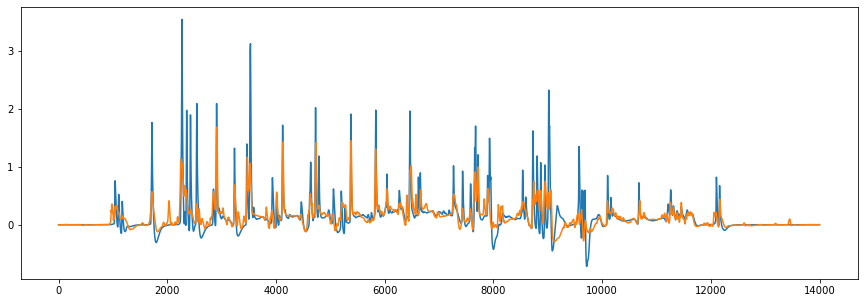

In [12]:
plt.figure(figsize = (15,5))
plt.plot(V_test.cpu().detach().numpy()[17000:28000])
plt.plot(test_V_pred.cpu().detach().numpy()[7000:18000])

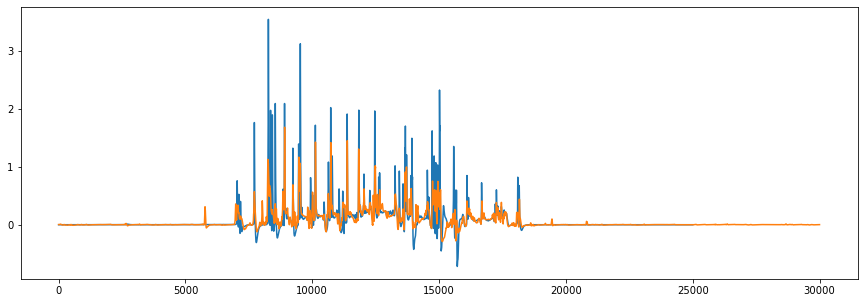

In [10]:
plt.figure(figsize = (15,5))
plt.plot(V_test.cpu().detach().numpy()[10000:35000])
plt.plot(test_V_pred.cpu().detach().numpy())

In [18]:
kern_basis = torch.zeros(21, T_no).to(device)
for i in range(21):
    phi = 1.5707963267948966*i
    xmin = phi - 3.141592653589793
    xmax = phi + 3.141592653589793

    x_in = torch.arange(0, T_no, 1)
    raw_cos = 5.5  * torch.log(x_in + 1 + 1e-7)

    basis = 0.5*torch.cos(raw_cos - phi) + 0.5
    basis[raw_cos < xmin] = 0.0
    basis[raw_cos > xmax] = 0.0
    kern_basis[i] = basis
    
kern_e = torch.matmul(model.W_e_layer1, kern_basis)
kern_i = torch.matmul(model.W_i_layer1, kern_basis)

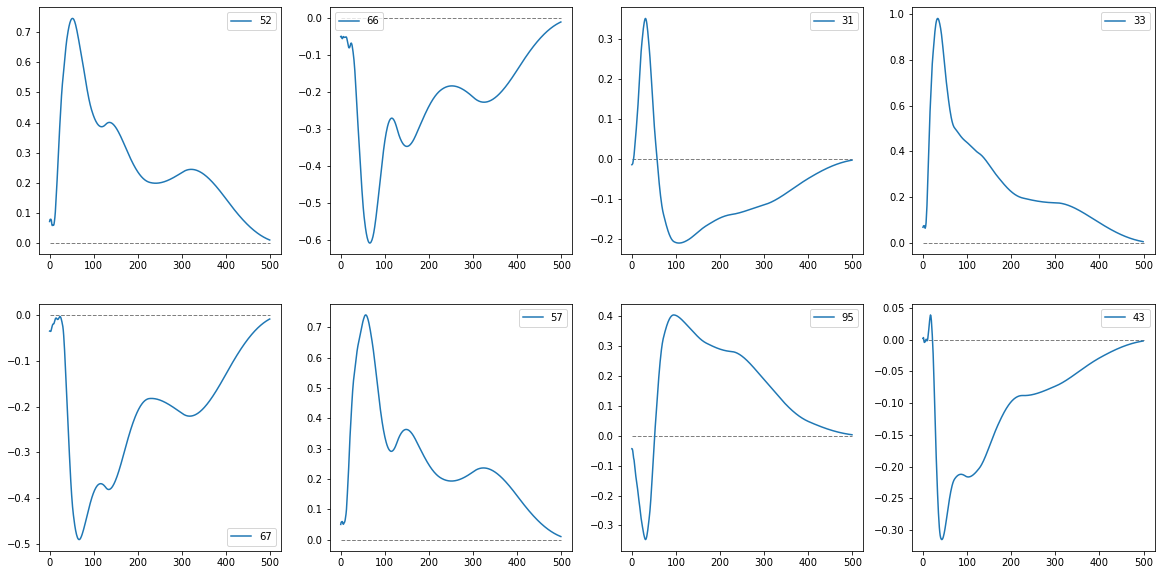

In [19]:
fig, axs = plt.subplots(nrows = H_no, ncols= sub_no, figsize = (20,10))

for i in range(H_no):
    for j in range(sub_no):
        idx = j*H_no + i
        max_t = np.argmax(np.abs(kern_e[idx].cpu().detach().numpy()))
        axs[i,j].plot(kern_e[idx].cpu().detach().numpy(), label=str(max_t))
        axs[i,j].hlines(y=0, xmin=0, xmax=T_no, linewidth=1, linestyle="--", color="gray")
        axs[i,j].legend()